# License 
***
Copyright (C) 2017 -- 2022 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

1. Standard Python imports and config

In [1]:
# imports
import numpy as np
import pandas as pd

# to upload local files
import io
from google.colab import files  

# display matplotlib graphics in notebook
%matplotlib inline

# random seed for better reproducibility
SEED = 12345

2. Install Java

In [2]:
# install Java for h2o backend
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


3. Install h2o

In [3]:
# install h2o
!pip install h2o 

     |████████████████████████████████| 176.2 MB 76 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.3-py2.py3-none-any.whl size=176244303 sha256=1f53e5a83d7ed769cc34ef04dd6583d9a2fbe8301c01a9b298346925c4eb5d65
  Stored in directory: /root/.cache/pip/wheels/b5/71/a5/02087a05e5644158183e1c58eeae3f9356a4d1e80659fb2dfb
Successfully built h2o


4. Import h2o package and required classes

In [4]:
# import h2o
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

5. Start h2o Server

In [5]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14" 2022-01-18; OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxy2ww6go
  JVM stdout: /tmp/tmpxy2ww6go/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxy2ww6go/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_58vywz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


6. Upload example data

In [6]:
# special google collab command to upload a file from computer
uploaded = files.upload() # REQUIRES STUDENT INPUT

Saving Assignment 7 Data to Assignment 7 Data


In [7]:
# 7
uploaded.keys() # what is stored in that Python object?

dict_keys(['Assignment 7 Data'])

8. Covert to Pandas DataFrame

In [8]:
# convert data to Pandas DataFrame
raw = pd.read_csv(io.StringIO(uploaded['Assignment 7 Data'].decode('utf-8'))) # name in quotes here must match name above

9. Convert to H2O Frame

In [9]:
frame = h2o.H2OFrame(raw) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


10. Split into train, validation, and test partitions -- with seed!!

In [10]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3], seed=SEED) # REQUIRES STUDENT INPUT

11. Assign modeling roles

In [11]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name not in ['id', '_WARN_', y, 'GRP_home_ownership']]
print(y)
print(X)
print(len(X))

bad_loan
['GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_purpose', 'GRP_verification_status', 'STD_IMP_REP_annual_inc', 'STD_IMP_REP_delinq_2yrs', 'STD_IMP_REP_dti', 'STD_IMP_REP_emp_length', 'STD_IMP_REP_int_rate', 'STD_IMP_REP_loan_amnt', 'STD_IMP_REP_longest_credit_lengt', 'STD_IMP_REP_revol_util', 'STD_IMP_REP_term_length', 'STD_IMP_REP_total_acc']
14


12. Set measurment level across data partitions (just to be sure)

In [12]:
# set target to factor - for binary classification
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

13. Train a random forest -- grid search not needed

In [13]:
# random forest

# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=500,                      # Up to 500 decision trees in the forest 
    max_depth=30,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_tree_interval=3,           # makes early stopping reproducible
    seed=SEED)                           # REQUIRES STUDENT INPUT

# train rf model
rf_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
rf_model

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1647927511737_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,147.0,147.0,18752767.0,30.0,30.0,30.0,9886.0,10380.0,10138.429




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.14890087873969196
RMSE: 0.3858767662605407
LogLoss: 0.4821926602255969
Mean Per-Class Error: 0.38399662317086247
AUC: 0.6574978148782963
AUCPR: 0.30681928161860805
Gini: 0.31499562975659257

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2115462868220988: 


,,0,1,Error,Rate
0,0,32730.0,20317.0,0.383,(20317.0/53047.0)
1,1,4859.0,7762.0,0.385,(4859.0/12621.0)
2,Total,37589.0,28079.0,0.3834,(25176.0/65668.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.211546,0.381425,238.0
1,max f2,0.090967,0.555386,336.0
2,max f0point5,0.296438,0.332529,171.0
3,max accuracy,0.688569,0.807958,10.0
4,max precision,0.800000,1.000000,0.0
5,max recall,0.000060,1.000000,399.0
6,max specificity,0.800000,1.000000,0.0
7,max absolute_mcc,0.235280,0.186812,218.0
8,max min_per_class_accuracy,0.211546,0.615007,238.0
9,max mean_per_class_accuracy,0.212894,0.616011,237.0



Gains/Lift Table: Avg response rate: 19.22 %, avg score: 20.58 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010066,0.543860,2.448042,2.448042,0.470499,0.596283,0.470499,0.596283,0.024641,0.024641,144.804249,144.804249,0.018044
1,2,0.020665,0.500000,2.235229,2.338891,0.429598,0.516741,0.449521,0.555486,0.023691,0.048332,123.522873,133.889115,0.034250
2,3,0.030136,0.471698,1.940697,2.213739,0.372990,0.482760,0.425467,0.532628,0.018382,0.066714,94.069650,121.373851,0.045280
3,4,0.040172,0.450000,1.910689,2.138034,0.367223,0.459814,0.410917,0.514439,0.019174,0.085889,91.068887,113.803354,0.056594
4,5,0.050009,0.432600,1.820271,2.075526,0.349845,0.440801,0.398904,0.499953,0.017907,0.103795,82.027056,107.552596,0.066583
5,6,0.100795,0.375000,1.777002,1.925114,0.341529,0.400493,0.369995,0.449840,0.090246,0.194042,77.700197,92.511389,0.115432
6,7,0.150012,0.334323,1.576055,1.810592,0.302908,0.354290,0.347985,0.418491,0.077569,0.271611,57.605498,81.059167,0.150530
7,8,0.200097,0.306122,1.406365,1.709412,0.270295,0.320075,0.328539,0.393857,0.070438,0.342049,40.636455,70.941183,0.175725
8,9,0.300207,0.259259,1.315411,1.578025,0.252814,0.281167,0.303287,0.356279,0.131685,0.473734,31.541062,57.802480,0.214813
9,10,0.400210,0.220339,1.124282,1.464645,0.216080,0.239107,0.281496,0.327000,0.112432,0.586166,12.428237,46.464530,0.230199




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.14629871076829074
RMSE: 0.38249014466818715
LogLoss: 0.4616248896308078
Mean Per-Class Error: 0.3755159960744664
AUC: 0.6687278675485067
AUCPR: 0.31864996740887946
Gini: 0.3374557350970133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21201875189647293: 


,,0,1,Error,Rate
0,0,24995.0,14786.0,0.3717,(14786.0/39781.0)
1,1,3567.0,5836.0,0.3793,(3567.0/9403.0)
2,Total,28562.0,20622.0,0.3731,(18353.0/49184.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.212019,0.388743,228.0
1,max f2,0.107532,0.557558,330.0
2,max f0point5,0.302683,0.346952,151.0
3,max accuracy,0.530642,0.809572,37.0
4,max precision,0.809524,1.000000,0.0
5,max recall,0.006825,1.000000,398.0
6,max specificity,0.809524,1.000000,0.0
7,max absolute_mcc,0.265299,0.199917,181.0
8,max min_per_class_accuracy,0.212019,0.620653,228.0
9,max mean_per_class_accuracy,0.212019,0.624484,228.0



Gains/Lift Table: Avg response rate: 19.12 %, avg score: 20.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010776,0.517007,2.684420,2.684420,0.513208,0.565948,0.513208,0.565948,0.028927,0.028927,168.441987,168.441987,0.022441
1,2,0.020474,0.476190,2.171222,2.441326,0.415094,0.492886,0.466733,0.531340,0.021057,0.049984,117.122195,144.132612,0.036485
2,3,0.030213,0.452381,2.183996,2.358378,0.417537,0.462464,0.450875,0.509138,0.021270,0.071254,118.399627,135.837794,0.050742
3,4,0.040115,0.433107,2.126638,2.301177,0.406571,0.441916,0.439939,0.492546,0.021057,0.092311,112.663834,130.117713,0.064534
4,5,0.050016,0.416478,2.072935,2.255993,0.396304,0.424795,0.431301,0.479133,0.020525,0.112836,107.293535,125.599268,0.077669
5,6,0.100012,0.365494,1.767665,2.011878,0.337942,0.389172,0.384631,0.434161,0.088376,0.201212,76.766476,101.187836,0.125121
6,7,0.150008,0.327878,1.642163,1.888657,0.313949,0.345729,0.361073,0.404688,0.082101,0.283314,64.216269,88.865651,0.164815
7,8,0.205331,0.299320,1.499421,1.783784,0.286659,0.312323,0.341024,0.379802,0.082952,0.366266,49.942059,78.378366,0.198975
8,9,0.301318,0.255102,1.267504,1.619320,0.242322,0.275373,0.309582,0.346535,0.121663,0.487929,26.750428,61.931976,0.230721
9,10,0.409706,0.217687,1.125414,1.488656,0.215157,0.234714,0.284601,0.316953,0.121982,0.609912,12.541356,48.865558,0.247528




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-03-22 05:41:59,0.072 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-03-22 05:42:03,3.807 sec,3.0,0.513832,8.053770,0.544216,0.220925,1.313733,0.808272,0.443574,3.548991,0.566346,0.235196,1.708604,0.446812
2,,2022-03-22 05:42:05,5.784 sec,6.0,0.476615,5.579207,0.556369,0.227987,1.369955,0.808385,0.413832,1.841185,0.592070,0.253520,1.770456,0.579050
3,,2022-03-22 05:42:07,7.485 sec,9.0,0.449907,3.919209,0.570496,0.236631,1.418812,0.462185,0.403533,1.213199,0.606540,0.264383,1.984409,0.470031
4,,2022-03-22 05:42:09,9.121 sec,12.0,0.432502,2.901628,0.581961,0.245185,1.554825,0.484239,0.397996,0.903848,0.617814,0.273494,2.095732,0.411374
5,,2022-03-22 05:42:10,10.668 sec,15.0,0.421465,2.271402,0.590960,0.251174,1.672856,0.520114,0.394732,0.725500,0.624969,0.279639,2.074612,0.478814
6,,2022-03-22 05:42:12,12.465 sec,18.0,0.414812,1.869776,0.597497,0.254666,1.765525,0.484213,0.392585,0.643571,0.630469,0.284258,2.249582,0.430587
7,,2022-03-22 05:42:13,14.067 sec,21.0,0.409802,1.578492,0.604030,0.259479,1.776087,0.434282,0.390621,0.591420,0.636587,0.290269,2.275129,0.394925
8,,2022-03-22 05:42:15,15.861 sec,24.0,0.405693,1.338550,0.610376,0.264834,2.015477,0.448544,0.389560,0.556942,0.639641,0.293248,2.345629,0.440651
9,,2022-03-22 05:42:17,17.808 sec,27.0,0.402779,1.180079,0.615740,0.268445,1.924928,0.430042,0.388659,0.526687,0.642644,0.295500,2.426275,0.409564



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,STD_IMP_REP_int_rate,121081.812500,1.000000,0.127823
1,STD_IMP_REP_dti,100286.968750,0.828258,0.105870
2,STD_IMP_REP_revol_util,99001.429688,0.817641,0.104513
3,STD_IMP_REP_annual_inc,94149.398438,0.777568,0.099391
4,STD_IMP_REP_loan_amnt,90047.460938,0.743691,0.095061
5,STD_IMP_REP_total_acc,88280.398438,0.729097,0.093195
6,STD_IMP_REP_longest_credit_lengt,83754.976562,0.691722,0.088418
7,GRP_addr_state,79534.179688,0.656863,0.083962
8,STD_IMP_REP_emp_length,63915.921875,0.527874,0.067474
9,GRP_purpose,43672.796875,0.360688,0.046104


14. View random forest AUC across data partitions

In [14]:
# measure rf AUC
print(rf_model.auc(train=True))
print(rf_model.auc(valid=True))
print(rf_model.model_performance(test_data=test).auc())

0.6574978148782963
0.6687278675485067
0.6705123635782521


15. Calculate partial dependence for `STD_IMP_REP_int_rate`

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


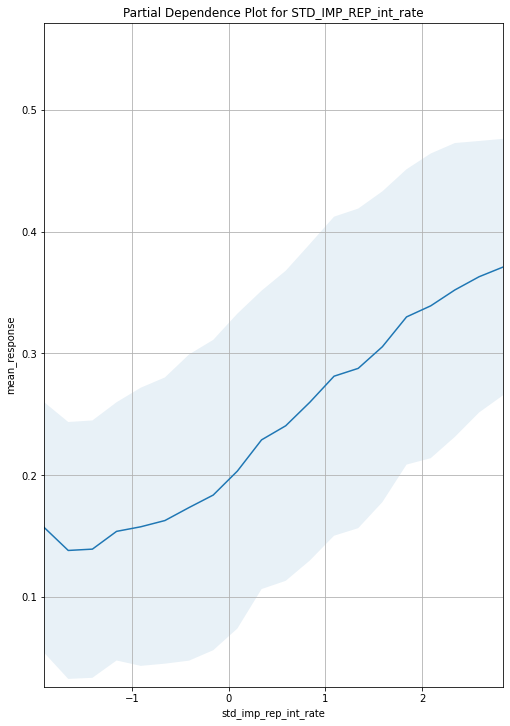

In [15]:
# partial dependence plots are an interpretation tool
pd0 = rf_model.partial_plot(data=train, cols=['STD_IMP_REP_int_rate'], plot=True)

16. Plot random forest feature importance

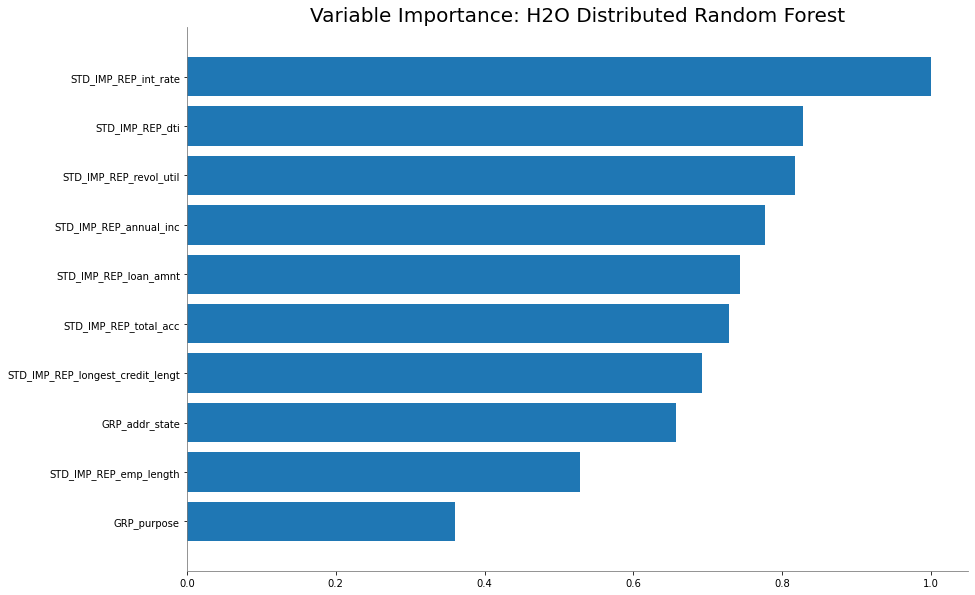

<Figure size 432x288 with 0 Axes>

In [16]:
_ = rf_model.varimp_plot()

17. Score new row of data

In [22]:
# predict on new data -- REQUIRES STUDENT INPUT
new_row = pd.DataFrame.from_dict({
  "GRP_REP_home_ownership": [1],
  "GRP_addr_state": [20],
  "GRP_purpose": [1],
  "GRP_verification_status": [1],
  "STD_IMP_REP_annual_inc": [4],
  "STD_IMP_REP_delinq_2yrs": [1],
  "STD_IMP_REP_dti": [1],
  "STD_IMP_REP_emp_length": [2],
  "STD_IMP_REP_int_rate": [1],
  "STD_IMP_REP_loan_amnt": [1],
  "STD_IMP_REP_longest_credit_lengt": [1],
  "STD_IMP_REP_revol_util": [1],
  "STD_IMP_REP_term_length":[1],
  "STD_IMP_REP_total_acc": [0]},
  orient='columns')

# generate prediction -- REQUIRES STUDENT INPUT
rf_model.predict(h2o.H2OFrame(new_row))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.755102,0.244898


18. Train GBM with random grid search

In [24]:
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(0, 500, 50)),
                    'max_depth':list(range(0, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600,
                   'seed': 12345} # REQUIRES STUDENT INPUT

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid,
              seed=12345) # REQUIRES STUDENTS INPUT

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
      col_sample_rate     max_depth  ntrees  sample_rate  \
0                 1.0  4.000000e+00   100.0          0.6   
1                 0.7  4.000000e+00   450.0          0.9   
2                 0.9  2.000000e+00   250.0          0.4   
3                 0.8  6.000000e+00   100.0          0.6   
4                 0.2  2.000000e+00   100.0          0.7   
5                 0.1  1.200000e+01   100.0          0.5   
6                 0.2  1.000000e+01   150.0          0.6   
7                 0.9  1.000000e+01   200.0          0.8   
8                 0.1  1.600000e+01   200.0          0.5   
9                 0.6  8.000000e+00   250.0          0.3   
10                0.3  2.000000e+00     0.0          0.9   
11                0.5  1.600000e+01     0.0          1.0   
12                0.4  1.800000e+01     0.0          0.4   
13                0.2  2.147484e+09    50.0          0.9   
14   

19. View grid search results

In [25]:
# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

      col_sample_rate     max_depth  ntrees  sample_rate  \
0                 1.0  4.000000e+00   100.0          0.6   
1                 0.7  4.000000e+00   450.0          0.9   
2                 0.9  2.000000e+00   250.0          0.4   
3                 0.8  6.000000e+00   100.0          0.6   
4                 0.2  2.000000e+00   100.0          0.7   
5                 0.1  1.200000e+01   100.0          0.5   
6                 0.2  1.000000e+01   150.0          0.6   
7                 0.9  1.000000e+01   200.0          0.8   
8                 0.1  1.600000e+01   200.0          0.5   
9                 0.6  8.000000e+00   250.0          0.3   
10                0.3  2.000000e+00     0.0          0.9   
11                0.5  1.600000e+01     0.0          1.0   
12                0.4  1.800000e+01     0.0          0.4   
13                0.2  2.147484e+09    50.0          0.9   
14                0.9  1.200000e+01   400.0          0.7   
15                0.1  1.800000e+01   30

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,24732.0,4.0,4.0,4.0,10.0,16.0,15.07




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1402385222235306
RMSE: 0.374484341760147
LogLoss: 0.4432031028805026
Mean Per-Class Error: 0.34845985448675176
AUC: 0.7123914577058269
AUCPR: 0.3856565979483582
Gini: 0.4247829154116538

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21728130612852697: 


,,0,1,Error,Rate
0,0,38089.0,14958.0,0.282,(14958.0/53047.0)
1,1,5237.0,7384.0,0.4149,(5237.0/12621.0)
2,Total,43326.0,22342.0,0.3075,(20195.0/65668.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.217281,0.422389,218.0
1,max f2,0.126007,0.577714,312.0
2,max f0point5,0.311035,0.401336,143.0
3,max accuracy,0.469691,0.812770,54.0
4,max precision,0.784478,1.000000,0.0
5,max recall,0.029997,1.000000,397.0
6,max specificity,0.784478,1.000000,0.0
7,max absolute_mcc,0.232057,0.255260,205.0
8,max min_per_class_accuracy,0.196698,0.651295,238.0
9,max mean_per_class_accuracy,0.182509,0.653125,253.0



Gains/Lift Table: Avg response rate: 19.22 %, avg score: 19.25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010005,0.516568,3.579588,3.579588,0.687976,0.568674,0.687976,0.568674,0.035813,0.035813,257.958837,257.958837,0.031949
1,2,0.020010,0.471156,2.906436,3.243012,0.558600,0.491627,0.623288,0.530151,0.029079,0.064892,190.643569,224.301203,0.055560
2,3,0.030015,0.443677,2.565900,3.017308,0.493151,0.456503,0.579909,0.505602,0.025671,0.090563,156.589963,201.730789,0.074955
3,4,0.040004,0.420598,2.308071,2.840201,0.443598,0.431457,0.545870,0.487087,0.023057,0.113620,130.807104,184.020117,0.091131
4,5,0.050009,0.402976,2.344155,2.740962,0.450533,0.411728,0.526797,0.472010,0.023453,0.137073,134.415521,174.096177,0.107778
5,6,0.100003,0.343228,2.065064,2.403064,0.396893,0.370950,0.461855,0.421488,0.103241,0.240314,106.506419,140.306444,0.173694
6,7,0.150012,0.305219,1.768158,2.191407,0.339829,0.322954,0.421176,0.388640,0.088424,0.328738,76.815799,119.140747,0.221248
7,8,0.200006,0.276328,1.559496,2.033454,0.299726,0.290235,0.390818,0.364042,0.077965,0.406703,55.949590,103.345364,0.255875
8,9,0.300009,0.231377,1.328697,1.798535,0.255368,0.252571,0.345668,0.326885,0.132874,0.539577,32.869735,79.853488,0.296566
9,10,0.399997,0.197733,1.073738,1.617356,0.206366,0.213963,0.310846,0.298658,0.107361,0.646938,7.373829,61.735642,0.305693




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14359348250011444
RMSE: 0.37893730682015786
LogLoss: 0.4531150506586152
Mean Per-Class Error: 0.3652268516720558
AUC: 0.6871991937416432
AUCPR: 0.3385629649032185
Gini: 0.37439838748328635

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19926430359243252: 


,,0,1,Error,Rate
0,0,26224.0,13557.0,0.3408,(13557.0/39781.0)
1,1,3664.0,5739.0,0.3897,(3664.0/9403.0)
2,Total,29888.0,19296.0,0.3501,(17221.0/49184.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.199264,0.399944,232.0
1,max f2,0.120942,0.567600,316.0
2,max f0point5,0.285795,0.363839,156.0
3,max accuracy,0.561246,0.809816,23.0
4,max precision,0.615249,0.675000,12.0
5,max recall,0.031589,1.000000,396.0
6,max specificity,0.759164,0.999975,0.0
7,max absolute_mcc,0.248042,0.222469,188.0
8,max min_per_class_accuracy,0.191726,0.634549,239.0
9,max mean_per_class_accuracy,0.184927,0.635707,246.0



Gains/Lift Table: Avg response rate: 19.12 %, avg score: 19.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.512071,2.679124,2.679124,0.512195,0.566124,0.512195,0.566124,0.026800,0.026800,167.912420,167.912420,0.020767
1,2,0.020007,0.468810,2.615336,2.647230,0.500000,0.488771,0.506098,0.527448,0.026162,0.052962,161.533553,164.722987,0.040745
2,3,0.030010,0.439178,2.381444,2.558634,0.455285,0.452835,0.489160,0.502577,0.023822,0.076784,138.144374,155.863449,0.057830
3,4,0.040013,0.417519,2.200709,2.469153,0.420732,0.428224,0.472053,0.483989,0.022014,0.098798,120.070917,146.915316,0.072680
4,5,0.050016,0.399830,2.158183,2.406959,0.412602,0.408427,0.460163,0.468876,0.021589,0.120387,115.818339,140.695920,0.087004
5,6,0.100012,0.343137,1.865514,2.136292,0.356649,0.368958,0.408416,0.418927,0.093268,0.213655,86.551384,113.629156,0.140505
6,7,0.150008,0.304999,1.740012,2.004216,0.332656,0.323152,0.383166,0.387006,0.086994,0.300649,74.001176,100.421620,0.186247
7,8,0.200004,0.275894,1.469863,1.870642,0.281009,0.289811,0.357629,0.362710,0.073487,0.374136,46.986324,87.064154,0.215291
8,9,0.299996,0.231145,1.336916,1.692745,0.255592,0.252296,0.323619,0.325908,0.133681,0.507817,33.691613,69.274513,0.256943
9,10,0.400008,0.196222,1.093135,1.542827,0.208986,0.213175,0.294958,0.297722,0.109327,0.617143,9.313475,54.282729,0.268459




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-03-22 06:29:50,5 min 49.184 sec,0.0,0.394025,0.489389,0.500000,0.192194,1.000000,0.807806,0.393232,0.487933,0.500000,0.191180,1.000000,0.808820
1,,2022-03-22 06:29:50,5 min 49.315 sec,1.0,0.391843,0.483946,0.666332,0.312955,2.516555,0.384921,0.391122,0.482681,0.662753,0.307825,2.501943,0.385878
2,,2022-03-22 06:29:51,5 min 49.412 sec,2.0,0.390135,0.479756,0.671168,0.320966,2.516555,0.392368,0.389490,0.478676,0.667509,0.313424,2.501943,0.392262
3,,2022-03-22 06:29:51,5 min 49.516 sec,3.0,0.388652,0.476179,0.673741,0.323419,2.580944,0.412042,0.388041,0.475182,0.670711,0.316992,2.458784,0.354445
4,,2022-03-22 06:29:51,5 min 49.611 sec,4.0,0.387409,0.473213,0.675352,0.325764,2.604721,0.383474,0.386836,0.472306,0.672460,0.319233,2.531539,0.384881
5,,2022-03-22 06:29:51,5 min 49.733 sec,5.0,0.386366,0.470712,0.677289,0.327814,2.592932,0.358729,0.385864,0.469969,0.673961,0.320471,2.548477,0.336898
6,,2022-03-22 06:29:51,5 min 49.888 sec,6.0,0.385489,0.468605,0.677933,0.328386,2.678734,0.370607,0.385041,0.467994,0.674237,0.320872,2.562178,0.365119
7,,2022-03-22 06:29:51,5 min 50.092 sec,7.0,0.384749,0.466847,0.678944,0.330579,2.708450,0.373911,0.384359,0.466355,0.675217,0.321628,2.523485,0.341270
8,,2022-03-22 06:29:51,5 min 50.302 sec,8.0,0.384090,0.465244,0.679681,0.331204,2.717244,0.370256,0.383727,0.464828,0.675885,0.322786,2.559690,0.359731
9,,2022-03-22 06:29:52,5 min 50.496 sec,9.0,0.383556,0.463948,0.680388,0.332083,2.770775,0.374292,0.383256,0.463679,0.676220,0.323017,2.604704,0.360402



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,STD_IMP_REP_int_rate,2459.498779,1.000000,0.545870
1,STD_IMP_REP_annual_inc,487.379547,0.198162,0.108171
2,STD_IMP_REP_dti,288.443237,0.117277,0.064018
3,STD_IMP_REP_loan_amnt,271.323303,0.110317,0.060219
4,STD_IMP_REP_revol_util,210.442520,0.085563,0.046706
5,GRP_purpose,152.928482,0.062179,0.033942
6,STD_IMP_REP_term_length,150.277557,0.061101,0.033353
7,STD_IMP_REP_total_acc,143.681305,0.058419,0.031889
8,STD_IMP_REP_longest_credit_lengt,112.220528,0.045627,0.024907
9,STD_IMP_REP_emp_length,85.090897,0.034597,0.018885


20. View GBM AUC across data partitions

In [26]:
# measure gbm AUC
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))
print(gbm_model.model_performance(test_data=test).auc())

0.7123914577058269
0.6871991937416432
0.690704261489394


21. Calculate partial dependence for `STD_IMP_REP_int_rate`

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


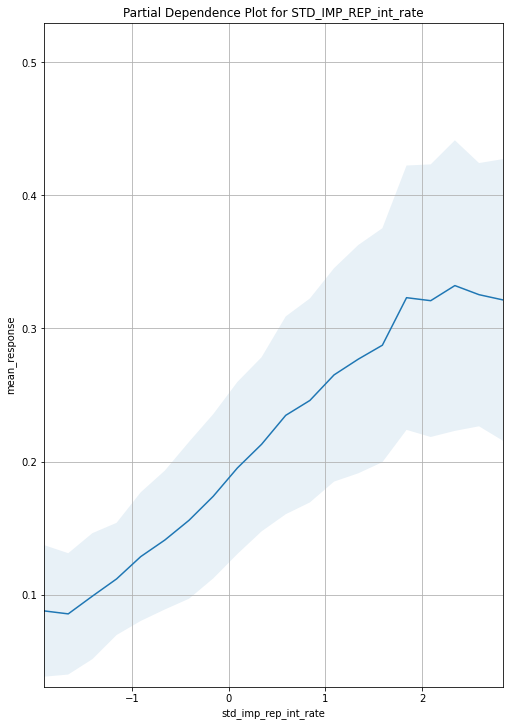

In [27]:
# partial dependence plots are an interpretation tool
pd1 = gbm_model.partial_plot(data=train, cols=['STD_IMP_REP_int_rate'], plot=True)

22. Plot GBM feature importance

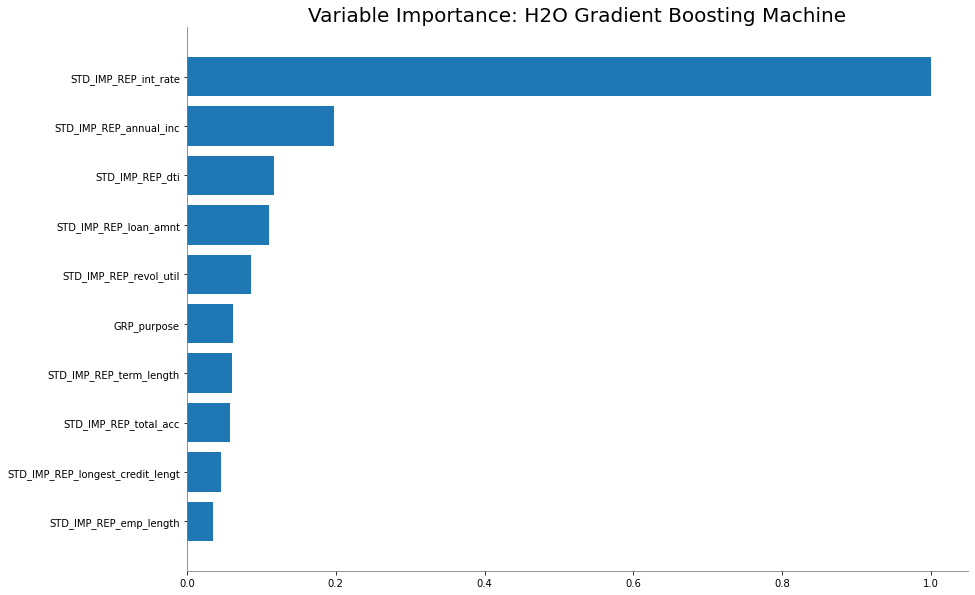

<Figure size 432x288 with 0 Axes>

In [28]:
_ = gbm_model.varimp_plot()

23. Score new row of data

In [29]:
# predict on new data -- REQUIRES STUDENT INPUT
new_row = pd.DataFrame.from_dict({
  "GRP_REP_home_ownership": [1],
  "GRP_addr_state": [20],
  "GRP_purpose": [1],
  "GRP_verification_status": [1],
  "STD_IMP_REP_annual_inc": [4],
  "STD_IMP_REP_delinq_2yrs": [1],
  "STD_IMP_REP_dti": [1],
  "STD_IMP_REP_emp_length": [2],
  "STD_IMP_REP_int_rate": [1],
  "STD_IMP_REP_loan_amnt": [1],
  "STD_IMP_REP_longest_credit_lengt": [1],
  "STD_IMP_REP_revol_util": [1],
  "STD_IMP_REP_term_length":[1],
  "STD_IMP_REP_total_acc": [0]},
  orient='columns')

# generate prediction -- REQUIRES STUDENT INPUT
gbm_model.predict(h2o.H2OFrame(new_row))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.763644,0.236356


24. Shutdown `h2o`

In [30]:
# shutdown h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_b434 closed.
